The following variables control which aspect of the data we want to analyze; either "accuracy", "time", or "effort". 

In [47]:
analysis_type = "effort"
aggregation = "mean"

tasks = ["T1", "T2", 'T3', "T4", "T5", "T6"]

Necessary packages

In [48]:
import pandas as pd 
import numpy as np 
import pylab as plt
import json 

Load in the data and set up some formatting

In [49]:
with open("CHI-format.json", 'r') as fdata:
    data = json.load(fdata)
data[0]["E"]['e']["T1"]
data = [d for i,d in enumerate(data) if i != 28]

In [50]:
def compute_aggregation(values):
    if not values: return None
    if aggregation == "mean":
        return sum(values) / len(values)
    elif aggregation == "median":
        from statistics import median
        return median(values)
    
def flatten(nested):
    return [x for xs in nested for x in xs]

Data format: 
```
[
    {
        'E': {
            'e': {
                'T1': {
                    'accuracy': [0,1,0],
                    'time': [2.3, 2.7, 4.91],
                    'effort': [3, 5, 9]
                }, 
                ...
            }, 
            ...
        }, 
        ...
    }, 
    ...
]
```
Each entry is a participant, their responses partitioned by geometry, graph type, and task type. 

In [51]:
factors = list()
for i,participant in enumerate(data):
    for geom in 'EHS':
        # for gtype in 'ehs':
        aggregatelist = flatten([participant[geom][gtype][t][analysis_type] for t in tasks for gtype in 'ehs'])
        factors.append([compute_aggregation(aggregatelist), f'p_{i}', f'{geom}'])

h1 = pd.DataFrame([factor for factor in factors], columns=["values", 'participants', "groups"])
h1.to_csv(f"CHI-hypotheses/H2-{analysis_type}.csv", index=False)

In [52]:
results = dict()
for geom in "EHS":
    # for gtype in 'ehs':
        # results[f'{gtype}({geom})'] = [compute_aggregation(p[geom][gtype][t][analysis_type]) for p in data for t in tasks]
    intermediate = list()
    for p in data:
        tmp = [p[geom][gtype][t][analysis_type] for t in tasks for gtype in 'ehs' if p[geom][gtype][t][analysis_type]]
        tmp = flatten(tmp)
        intermediate.append(compute_aggregation(tmp))
        results[f'{geom}'] = intermediate
        # results[f'{gtype}({geom})'] = [p for p in results[f'{gtype}({geom})'] if p]
        # print(results[f'{gtype}({geom})'])

In [53]:
results_chart = {
    g: [list(), list()] for g in "EHS"
}
for geom in "EHS":
    # for gtype in 'ehs':
        # results[f'{gtype}({geom})'] = [compute_aggregation(p[geom][gtype][t][analysis_type]) for p in data for t in tasks]
    intermediate = [list(), list()]
    for p in data:
        tmp1 = [p[geom][gtype][t]["time"] for t in tasks for gtype in 'ehs' if p[geom][gtype][t][analysis_type]]
        tmp1 = flatten(tmp1)
        tmp2 = [p[geom][gtype][t]["accuracy"] for t in tasks for gtype in 'ehs' if p[geom][gtype][t][analysis_type]]
        tmp2 = flatten(tmp2)        
        # intermediate.append(compute_aggregation(tmp))
        results_chart[f'{geom}'][0].extend(tmp1)
        results_chart[f'{geom}'][1].extend(tmp2)
        # results[f'{gtype}({geom})'] = [p for p in results[f'{gtype}({geom})'] if p]
        # print(results[f'{gtype}({geom})'])

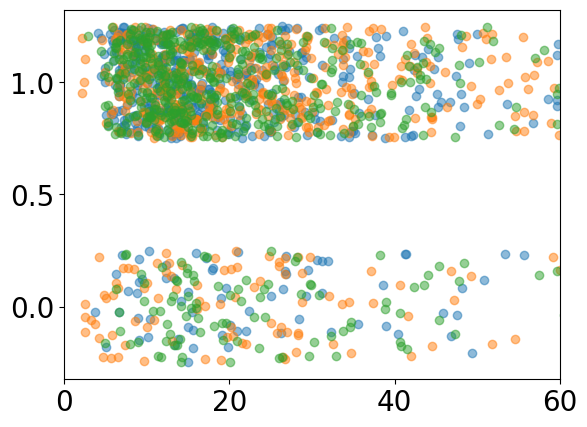

In [54]:
plt.xlim(0,60)
for g in "EHS":
    plt.scatter(results_chart[g][0], results_chart[g][1] + np.random.uniform(-0.25,0.25,size=len(results_chart[g][1])), alpha=0.5)

In [55]:
df = pd.DataFrame(results)
df.head()

,E,H,S
0,0.000000,2.555556,1.277778
1,0.000000,7.111111,3.055556
2,0.500000,11.777778,1.444444
3,0.055556,2.888889,0.555556
4,0.000000,7.277778,2.111111


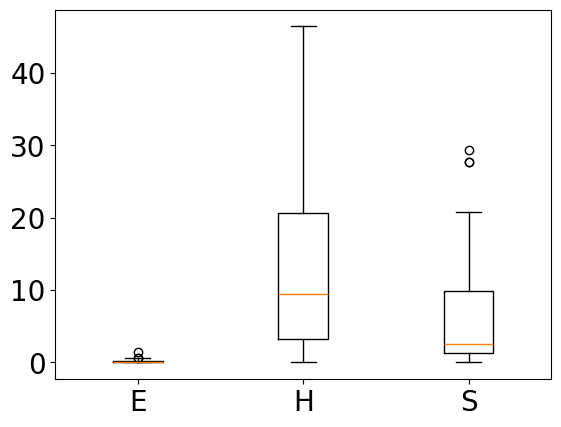

In [56]:
plt.boxplot(df[["E", "H", "S"]].to_numpy(), labels=["E", "H", "S"])
# plt.suptitle(f"H1a with {analysisType}")
# plt.savefig(f"hypotheses/H1a_{analysisType}.png")
plt.show()


In [57]:
import scipy.stats as st


In [58]:
labels = list()
means = list()
for geom in "EHS":
    lab = f"{geom}"
    labels.append(lab)
    mean = compute_aggregation(results[lab])
    CI = st.t.interval(confidence=0.95, df=len(results[lab])-1, loc=mean, scale=st.sem(results[lab]))
    means.append( (mean, CI[0], CI[1], results[lab]) )
means = means[::-1]
labels = labels[::-1]

In [59]:
labels

['S', 'H', 'E']

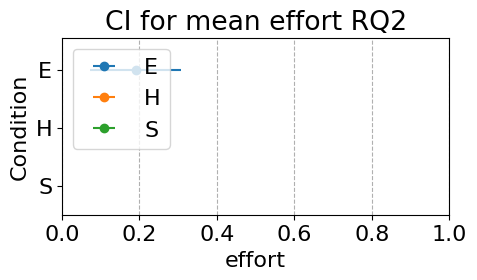

In [60]:
plt.rcParams.update({'font.size': 16})


colors = ["tab:blue", "tab:orange", "tab:green"][::-1]
fig, ax = plt.subplots()
error_plots = list()
for i,(mean, low, high,values) in enumerate(means):
    y = i/10 
    sd = 1 / 30
    scaterY = np.random.uniform(y-sd, y + sd,size=len(values))
    # ax.scatter(values, scaterY,c=colors[i%3],alpha=0.2)
    err = ax.errorbar(mean, [i/10], xerr=[abs(high - mean)], fmt='o',color=colors[i%3])
    error_plots.append(err)
    

xmin = 0.
xmax = max(means, key=lambda x: x[2])[2] 
xmax = 1
ax.set_xlim(xmin, xmax)
ax.legend(error_plots[::-1],["E", "H", "S"],loc="upper left")

ax.set_yticks([i / 10 for i in range(3)], labels=labels)
ax.set_ylim(-0.05, 2/10 + 0.055)
# ax.hlines([0-0.05, 0.25, (5/10 + 0.05), 8/10 + 0.05], xmin, xmax, colors="black")
ax.grid(True,axis='x',linestyle='--')

# ax.axhspan(-0.05,0.27,facecolor="grey",alpha=0.2)
# ax.axhspan(0.25, 0.55,facecolor="grey",alpha=0.2)
# ax.axhspan(0.55,0.85, facecolor='grey', alpha=0.2)


ax.set_xlabel(analysis_type)
ax.set_ylabel("Condition")
ax.set_title(f"CI for {aggregation} {analysis_type} RQ2")

# ax2 = ax.twinx()
# ax2.set_ylim(-0.05, 8/10 + 0.055)
# ax2.set_yticks([i / 10 for i in range(1,9,3)], ["H1c", "H1b", "H1a"])

fig.set_size_inches(5,2.3)
fig.savefig(f"figures/RQ2vis_{analysis_type}.pdf",)

In [61]:
df.head()

,E,H,S
0,0.000000,2.555556,1.277778
1,0.000000,7.111111,3.055556
2,0.500000,11.777778,1.444444
3,0.055556,2.888889,0.555556
4,0.000000,7.277778,2.111111


In [62]:
full_factors = h1

In [63]:
import ptitprince as pt

Text(0.5, 0.98, 'Distribution of mean effort')

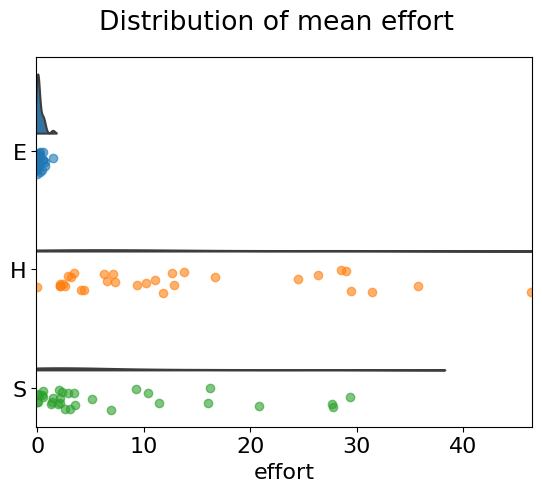

In [64]:
fig,axes = plt.subplots()

pt.half_violinplot(x='values',y='groups',data=h1,inner=None,width=1,ax=axes)


groups = ['E', "H", "S"]

minx = np.min(full_factors['values'])
maxx = np.max(full_factors['values'])
for i, group in enumerate(groups):
    data = full_factors[full_factors['groups'] == group]
    y = (i%3) + np.random.uniform(high=0.2, size=len(data))
    x = data['values']

    ax = axes

    ax.set_xlim(minx-0.1,maxx+0.1)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.scatter(x,y,alpha=0.6)

axes.set_xlabel(analysis_type)
fig.suptitle(f"Distribution of {aggregation} {analysis_type}")
# fig.set_size_inches(10,5)
# fig.savefig(f"figures/RQ1_{analysis_type}_raincloud.pdf")

<Axes: xlabel='groups', ylabel='values'>

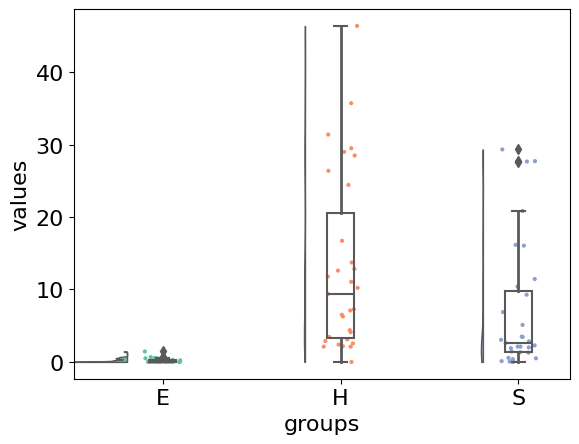

In [65]:
pt.RainCloud(x='groups',y='values',data=h1,bw=0.2,cut=0,orient='v',)

In [66]:
groups = ['E', 'H', 'S']

wilcox = dict()
for g1 in groups:
    wilcox[g1] = dict()
    for g2 in groups: 
        if g1 == g2:
            wilcox[g1][g2] = 0
            continue
        x = df[g1].to_numpy()
        y = df[g2].to_numpy()
        wilcox[g1][g2] = st.wilcoxon(x,y)[1]

wilcoxdf = pd.DataFrame(wilcox)


In [67]:
wilcoxdf

,E,H,S
E,0.000000,0.000002,0.000002
H,0.000002,0.000000,0.000003
S,0.000002,0.000003,0.000000


In [68]:
df.head()

,E,H,S
0,0.000000,2.555556,1.277778
1,0.000000,7.111111,3.055556
2,0.500000,11.777778,1.444444
3,0.055556,2.888889,0.555556
4,0.000000,7.277778,2.111111


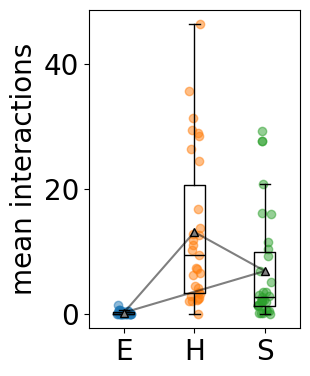

In [70]:
plt.rcParams.update({'font.size': 20})

fig,ax = plt.subplots()
fig.set_dpi(100)

offsets = [1,2,3]
ax.scatter(np.random.uniform(offsets[0]-0.1, offsets[0]+0.1,size=len(results['E'])), results['E'],alpha=0.5)
ax.scatter(np.random.uniform(offsets[1]-0.1, offsets[1]+0.1,size=len(results['E'])), results['H'],alpha=0.5)
ax.scatter(np.random.uniform(offsets[2]-0.1, offsets[2]+0.1,size=len(results['E'])), results['S'],alpha=0.5)

D = np.array([results['E'], results['H'], results['S']]).T
boxplot = ax.boxplot(D, labels=['E', "H", "S"],showfliers=False,medianprops={"color": "black"},showmeans=True,meanprops={"markerfacecolor":"grey", 'markeredgecolor': "black"})

bmeans = boxplot['means']
p1 = bmeans[0]
p2 = bmeans[1]
p3 = bmeans[2]
ax.plot([p1.get_xdata(), p2.get_xdata()], [p1.get_ydata(), p2.get_ydata()], alpha=0.5,color='black') 
ax.plot([p1.get_xdata(), p3.get_xdata()], [p1.get_ydata(), p3.get_ydata()], alpha=0.5,color='black') 
ax.plot([p2.get_xdata(), p3.get_xdata()], [p2.get_ydata(), p3.get_ydata()], alpha=0.5,color='black') 


# scatter_data = df['s(E)'].to_numpy()
# plt.scatter(np.random.uniform(0.9,1.1,size=len(scatter_data)), scatter_data,alpha=0.5)

# plt.boxplot(df[['s(E)', 's(H)', 's(S)']].to_numpy(), labels=["E", "H", "S"],showfliers=False)

# plt.show()

# axes[0].set_ylabel(f'{aggregation} {analysis_type}')
ax.set_ylabel(f"{aggregation} {analysis_type if 'effort' not in analysis_type else "interactions"}")
fig.tight_layout()
fig.set_size_inches(2.7,4)
fig.savefig(f"figures/CHI_RQ2_{analysis_type}.pdf",bbox_inches="tight")